In [1]:
#setup
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
from mpl_toolkits import mplot3d
plotly.tools.set_credentials_file(username='xavier2696', api_key='97cuXMXYTejnMxo9gpIk')
import re
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#keys
origin_time_key = 'Origin Time'
epicenter_longitude_key = 'EpicenterLongitude'
epicenter_latitude_key = 'EpicenterLatitude'
depth_key = 'Depth'
magnitude_key = 'Magnitude'
station_code_key = 'StationCode'
station_name_key = 'StationName'
station_longitude_key = 'StationLongitude'
station_latitude_key = 'StationLatitude'
instrument_kind_key = 'InstrumentKind'
start_time_key = 'StartTime'
record_length_key = 'RecordLength'
sample_rate_key = 'SampleRate'
amplitude_unit_key = 'AmplitudeUnit'
amplitude_max_u_key = 'AmplitudeMAX. U'
amplitude_max_n_key = 'AmplitudeMAX. N'
amplitude_max_e_key = 'AmplitudeMAX. E'

earthquake_column_names_dict = {origin_time_key: 'origin_time',
                               epicenter_longitude_key: 'epicenter_longitude',
                               epicenter_latitude_key: 'epicenter_latitude',
                               depth_key: 'depth',
                               magnitude_key: 'magnitude',
                               station_code_key: 'station_code',
                               station_name_key: 'station_name',
                               station_longitude_key: 'station_longitude',
                               station_latitude_key: 'station_latitude',
                               instrument_kind_key: 'instrument_kind',
                               start_time_key: 'start_time',
                               record_length_key: 'record_length',
                               sample_rate_key: 'sample_rate',
                               amplitude_unit_key: 'amplitude_unit',
                               amplitude_max_u_key: 'amplitude_max_u',
                               amplitude_max_n_key: 'amplitude_max_n',
                               amplitude_max_e_key: 'amplitude_max_e'}

earthquake_keys = [origin_time_key, epicenter_longitude_key, epicenter_latitude_key, depth_key, magnitude_key, \
                  station_code_key, station_name_key, station_longitude_key, station_latitude_key, \
                   instrument_kind_key, start_time_key, record_length_key, sample_rate_key, amplitude_unit_key, \
                  amplitude_max_u_key, amplitude_max_n_key, amplitude_max_e_key]

In [4]:
#method for creating a dictionary with the lines of the file
def earthquake_dict(lines_array):
    earthquake = {}
    
    readData_flag = 0
    time = []
    ux = []
    nx = []
    ex = []
    for line in earthquake_array:
        if ':' in line:
            for key in earthquake_keys:
                if key in line:
                    if '~' in line:
                        range_string = line.split(': ')[1]
                        lower = (range_string.split('~')[1]).strip()
                        upper = (range_string.split('~')[0]).strip()
                        earthquake[earthquake_column_names_dict[key] + '_lower'] = float(lower)
                        earthquake[earthquake_column_names_dict[key] + '_upper'] = float(upper)
                    else:
                        try:
                            value = float((line.split(': ')[1]).strip())
                            earthquake[earthquake_column_names_dict[key]] = value
                        except ValueError:
                            earthquake[earthquake_column_names_dict[key]] = (line.split(': ')[1]).strip()
        if readData_flag == 1:
            if line != '':
                t, u, n, e = line.split()
                time.append(t)
                ux.append(u)
                nx.append(n)
                ex.append(e)
        if 'ata' in line and 'equ' not in line:
            readData_flag = 1
    
    earthquake['time'] = np.asarray(time, dtype=np.float64)
    earthquake['ua'] = np.asarray(ux, dtype=np.float64)
    earthquake['na'] = np.asarray(nx, dtype=np.float64)
    earthquake['ea'] = np.asarray(ex, dtype=np.float64)
    return earthquake

In [5]:
#add data for the earthquakes
#get files for eq_cwb directory
earthquakes = []
for directory in os.listdir(os.getcwd() + '/data/earthquake/eq_cwb/2017ASCII'):
    path = os.getcwd() + '/data/earthquake/eq_cwb/2017ASCII/' + directory
    if os.path.isdir(path):
        for file in os.listdir(path):
            with open(path + '/' + file,"r") as file:
                earthquake_array = [string for string in file.read().split('\n')]
                earthquakes += [earthquake_dict(earthquake_array)]

#get files for eq_ncree directory
for directory in os.listdir(os.getcwd() + '/data/earthquake/eq_ncree/106'):
    path = os.getcwd() + '/data/earthquake/eq_ncree/106/' + directory
    if os.path.isdir(path):
        for file in os.listdir(path):
            with open(path + '/' + file, encoding='big5') as file:
                earthquake_array = [string for string in file.read().split('\n')]
                earthquakes += [earthquake_dict(earthquake_array)]

earthquake_df = pd.DataFrame.from_dict(earthquakes)
print('Length:', len(earthquake_df))

Length: 2338


In [6]:
print('Length unique earthquakes:', len(earthquake_df.start_time.unique()))

Length unique earthquakes: 575


In [7]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338 entries, 0 to 2337
Data columns (total 24 columns):
amplitude_max_e_lower    2338 non-null float64
amplitude_max_e_upper    2338 non-null float64
amplitude_max_n_lower    2338 non-null float64
amplitude_max_n_upper    2338 non-null float64
amplitude_max_u_lower    2338 non-null float64
amplitude_max_u_upper    2338 non-null float64
amplitude_unit           2338 non-null object
depth                    2338 non-null float64
ea                       2338 non-null object
epicenter_latitude       2338 non-null float64
epicenter_longitude      2338 non-null float64
instrument_kind          2338 non-null object
magnitude                2338 non-null float64
na                       2338 non-null object
origin_time              2338 non-null object
record_length            2338 non-null float64
sample_rate              2338 non-null float64
start_time               2338 non-null object
station_code             2338 non-null object
station

In [8]:
earthquake_df.to_pickle('data/earthquake/earthquakes_withData.pkl')

In [9]:
tainan_station = pd.DataFrame()

tainan_station = earthquake_df[(earthquake_df.station_latitude > 22.867997138821966) & 
                               (earthquake_df.station_latitude < 23.42151168812283) &
                               (earthquake_df.station_longitude > 120.0206129877014) &
                               (earthquake_df.station_longitude < 120.66239894252767)]

In [10]:
tainan_station.to_pickle('data/earthquake/earthquakes_Tainan_withData.pkl')

---

In [15]:
tainan_station = pd.read_pickle("data/earthquake/earthquakes_Tainan_withData.pkl")

In [11]:
tainan_station.head()

,amplitude_max_e_lower,amplitude_max_e_upper,amplitude_max_n_lower,amplitude_max_n_upper,amplitude_max_u_lower,amplitude_max_u_upper,amplitude_unit,depth,ea,epicenter_latitude,...,origin_time,record_length,sample_rate,start_time,station_code,station_latitude,station_longitude,station_name,time,ua
55,-4.606,3.410,-6.640,10.587,-0.658,0.658,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",23.28,...,2017/05/16-07:12:54,120.0,50.0,2017/05/16-07:12:48.000,SCK,23.147,120.086,Qigu,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
58,-2.393,2.452,-2.692,3.051,-1.436,1.555,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.28,...,2017/05/16-07:12:54,120.0,50.0,2017/05/16-07:12:48.000,SGS,23.080,120.591,Jiaxian,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
62,-12.920,9.451,-15.433,13.399,-1.794,1.914,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",23.28,...,2017/05/16-07:12:54,120.0,50.0,2017/05/16-07:12:48.000,SSH,23.136,120.288,Shanhua,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
66,-3.290,4.725,-6.041,5.264,-1.196,1.376,gal. DCoffset(corr),24.9,"[-0.06, 0.0, 0.0, 0.0, -0.06, -0.06, -0.06, -0...",23.28,...,2017/05/16-07:12:54,120.0,50.0,2017/05/16-07:12:48.000,TAI1,23.038,120.237,Yongkang,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.0, 0.0, 0.0, 0.0, 0.06, 0.0, -0.06, 0.0, 0...."
81,-9.571,8.673,-9.331,11.425,-3.110,2.752,gal. DCoffset(corr),24.9,"[-0.06, 0.0, 0.0, 0.0, -0.06, -0.06, 0.0, 0.0,...",23.28,...,2017/05/16-07:12:54,120.0,50.0,2017/05/16-07:12:48.000,CHN4,23.351,120.594,Caoshan,"[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
tainan_station.size

7608

In [13]:
tainan_station.instrument_kind.unique()

array(['FBA', 'Kinemetrics', 'TOKYO SOKUSHIN'], dtype=object)

In [14]:
tainan_station.reset_index(inplace=True)

In [15]:
tainan_station.iloc[176]

index                                                                 1287
amplitude_max_e_lower                                             -139.133
amplitude_max_e_upper                                               89.366
amplitude_max_n_lower                                             -353.574
amplitude_max_n_upper                                              221.978
amplitude_max_u_lower                                              -93.254
amplitude_max_u_upper                                              164.016
amplitude_unit                                         gal. DCoffset(corr)
depth                                                                 16.2
ea                       [0.0, 0.0, -0.06, 0.0, 0.0, -0.06, -0.06, 0.0,...
epicenter_latitude                                                   22.87
epicenter_longitude                                                 120.14
instrument_kind                                                        FBA
magnitude                

In [16]:
tainan_station.amplitude_max_n_lower.idxmin()

176

In [17]:
from scipy import integrate

def IntergrateTime(time, acc):
    dt = time[1] - time[0]

    for i in range(len(acc)):
        if acc[i] != 0:
            correction_time = i
            break
    
    dummy_time = time[correction_time:]
    dummy_acc = acc[correction_time:]
    
    # Least squares fit through acceleration history
    acc_fit = np.polyfit(dummy_time, dummy_acc, 1);
    cor_factor = np.polyval(acc_fit, dummy_time);
    acc_cor = dummy_acc - cor_factor;

    # Integrate for velocity
    velocity = integrate.cumtrapz(dummy_time, acc_cor, initial=0) *dt;

    # Least squares fit through velocity history
    vel_fit = np.polyfit(dummy_time, velocity, 1);
    vel_cor = acc_cor - vel_fit[0];

    # Corrected velocity
    vel_cor = integrate.cumtrapz(dummy_time, acc_cor, initial=0) *dt;

    # Corrected displacement
    dis_cor = integrate.cumtrapz(dummy_time, vel_cor, initial=0) *dt;
    
    acc_cor = np.append([0] * correction_time ,acc_cor)
    vel_cor = np.append([0] * correction_time ,vel_cor)
    dis_cor = np.append([0] * correction_time ,dis_cor)
    return acc_cor, vel_cor, dis_cor

In [18]:
e_PGA = []
e_PGV = []
e_PGD = []

n_PGA = []
n_PGV = []
n_PGD = []

u_PGA = []
u_PGV = []
u_PGD = []
for i in range(tainan_station.shape[0]):
    time = tainan_station.iloc[i].time
    
    acc = tainan_station.iloc[i].ea
    a, v, u = IntergrateTime(time, acc)
    e_PGA.append( np.absolute(a).max() )
    e_PGV.append( np.absolute(v).max() )
    e_PGD.append( np.absolute(u).max() )
    
    acc = tainan_station.iloc[i].na
    a, v, u = IntergrateTime(time, acc)
    n_PGA.append( np.absolute(a).max() )
    n_PGV.append( np.absolute(v).max() )
    n_PGD.append( np.absolute(u).max() )
    
    acc = tainan_station.iloc[i].ua
    a, v, u = IntergrateTime(time, acc)
    u_PGA.append( np.absolute(a).max() )
    u_PGV.append( np.absolute(v).max() )
    u_PGD.append( np.absolute(u).max() )

In [19]:
tainan_station['e_PGA'] = e_PGA
tainan_station['e_PGV'] = e_PGV
tainan_station['e_PGD'] = e_PGD

tainan_station['n_PGA'] = n_PGA
tainan_station['n_PGV'] = n_PGV
tainan_station['n_PGD'] = n_PGD

tainan_station['u_PGA'] = u_PGA
tainan_station['u_PGV'] = u_PGV
tainan_station['u_PGD'] = u_PGD

/home/lu/anaconda3/envs/NTHU_DataMining/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lu/anaconda3/envs/NTHU_DataMining/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/lu/anaconda3/envs/NTHU_DataMining/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [20]:
tainan_station.head()

,index,amplitude_max_e_lower,amplitude_max_e_upper,amplitude_max_n_lower,amplitude_max_n_upper,amplitude_max_u_lower,amplitude_max_u_upper,amplitude_unit,depth,ea,...,ua,e_PGA,e_PGV,e_PGD,n_PGA,n_PGV,n_PGD,u_PGA,u_PGV,u_PGD
0,55,-4.606,3.410,-6.640,10.587,-0.658,0.658,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.628052,4.687218,6.478251,10.563145,10.603392,10.643400,0.690667,1.434567,2.973917
1,58,-2.393,2.452,-2.692,3.051,-1.436,1.555,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.458348,1.965462,1.606147,3.037962,2.348394,1.838612,1.540904,1.145861,0.946072
2,62,-12.920,9.451,-15.433,13.399,-1.794,1.914,gal. DCoffset(corr),24.9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12.917770,12.114708,11.328676,15.395914,14.245179,15.105063,1.905965,2.462718,3.772364
3,66,-3.290,4.725,-6.041,5.264,-1.196,1.376,gal. DCoffset(corr),24.9,"[-0.06, 0.0, 0.0, 0.0, -0.06, -0.06, -0.06, -0...",...,"[0.0, 0.0, 0.0, 0.0, 0.06, 0.0, -0.06, 0.0, 0....",4.755222,5.613920,6.630136,6.019531,6.965000,8.051104,1.380711,1.986864,2.860498
4,81,-9.571,8.673,-9.331,11.425,-3.110,2.752,gal. DCoffset(corr),24.9,"[-0.06, 0.0, 0.0, 0.0, -0.06, -0.06, 0.0, 0.0,...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.543887,7.367929,5.688361,11.477485,8.968399,7.010468,3.081063,2.162007,1.644548


In [21]:
tainan_station.to_pickle('data/earthquake/earthquakes_Tainan_withData_withPeakValue.pkl')

---

In [22]:
tainan_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 34 columns):
index                    317 non-null int64
amplitude_max_e_lower    317 non-null float64
amplitude_max_e_upper    317 non-null float64
amplitude_max_n_lower    317 non-null float64
amplitude_max_n_upper    317 non-null float64
amplitude_max_u_lower    317 non-null float64
amplitude_max_u_upper    317 non-null float64
amplitude_unit           317 non-null object
depth                    317 non-null float64
ea                       317 non-null object
epicenter_latitude       317 non-null float64
epicenter_longitude      317 non-null float64
instrument_kind          317 non-null object
magnitude                317 non-null float64
na                       317 non-null object
origin_time              317 non-null object
record_length            317 non-null float64
sample_rate              317 non-null float64
start_time               317 non-null object
station_code             317 

In [23]:
tainan_station = tainan_station.drop(['amplitude_max_e_lower',
                                      'amplitude_max_e_upper',
                                      'amplitude_max_n_lower',
                                      'amplitude_max_n_upper',
                                      'amplitude_max_u_lower',
                                      'amplitude_max_u_upper'], axis = 1)

In [24]:
tainan_station.to_pickle('data/earthquake/earthquakes_Tainan_withData_withPeakValue_dropUseless.pkl')

---

In [25]:
time = tainan_station.iloc[2].time
acc = tainan_station.iloc[2].na

In [26]:
a, v, u = IntergrateTime(time, acc)

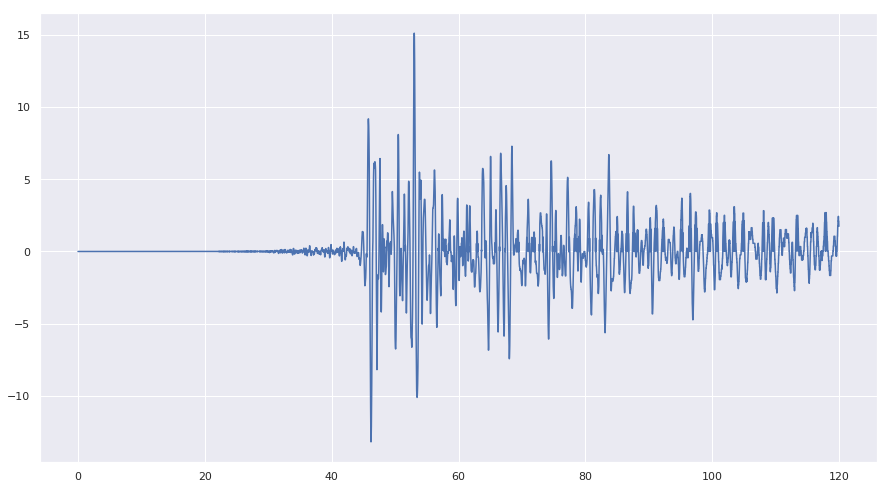

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(15,8.27)})
# sns.lineplot(time, acc)
sns.lineplot(time, u)

---

In [28]:
tainan_station.station_name.unique()

array(['Qigu', 'Jiaxian', 'Shanhua', 'Yongkang', 'Caoshan', 'Dongshan',
       'Xinhua', 'Jiali', 'Nanxi', 'Dapu', 'Tainan City', '嘉南國小', '新庄國小',
       '仁光國小', '塭內國小'], dtype=object)

In [33]:
tainan_station.groupby(['station_latitude', 'station_longitude']).size()

station_latitude  station_longitude
22.9889           120.5599             14
22.9930           120.2050             22
23.0380           120.2370             21
23.0760           120.3650             27
23.0800           120.5910             17
23.1253           120.1651              5
23.1360           120.2880             26
23.1470           120.0860             29
23.1740           120.2020             32
23.1850           120.5290             24
23.2175           120.3650             21
23.2440           120.6220             27
23.2640           120.5020             19
23.3000           120.2575              6
23.3510           120.5940             27
dtype: int64

In [46]:
np.sort(tainan_station.origin_time.unique())

array(['2017/01/04-15:07:21', '2017/01/12-01:31:03',
       '2017/01/13-01:46:42', '2017/01/25-15:33:06',
       '2017/02/11-01:12:52', '2017/02/11-01:15:40',
       '2017/02/12-12:30:58', '2017/03/08-06:10:51',
       '2017/03/24-01:09:25', '2017/03/25-23:02:58',
       '2017/03/30-00:34:02', '2017/04/17-02:34:16',
       '2017/04/30-09:57:22', '2017/05/16-07:12:54',
       '2017/05/24-17:49:03', '2017/05/24-21:10:54',
       '2017/05/25-13:48:11', '2017/05/25-13:48:12',
       '2017/06/16-05:29:18', '2017/06/22-07:36:04',
       '2017/07/18-03:16:26', '2017/07/30-09:00:07',
       '2017/08/10-00:05:36', '2017/08/11-09:58:54',
       '2017/09/20-22:29:56', '2017/09/20-22:29:57',
       '2017/10/26-01:23:55', '2017/11/03-10:48:15',
       '2017/11/03-10:48:59', '2017/11/04-07:34:48',
       '2017/11/07-01:36:40', '2017/11/11-19:14:39',
       '2017/11/11-20:13:04', '2017/11/11-20:22:53',
       '2017/11/11-20:24:43', '2017/11/11-21:39:38',
       '2017/11/22-22:20:09', '2017/11/23-06:1

In [30]:
import matplotlib.pyplot as plt
import geopandas as gp
import numpy as np
%matplotlib inline  

villages_shp = gp.read_file("./data/geographicPlot/VILLAGE_MOI_121_1071031.shp", encoding='utf8') #全台灣村里界圖
tainan_shp = villages_shp.query('COUNTYNAME=="臺南市"') #臺中市村里界圖

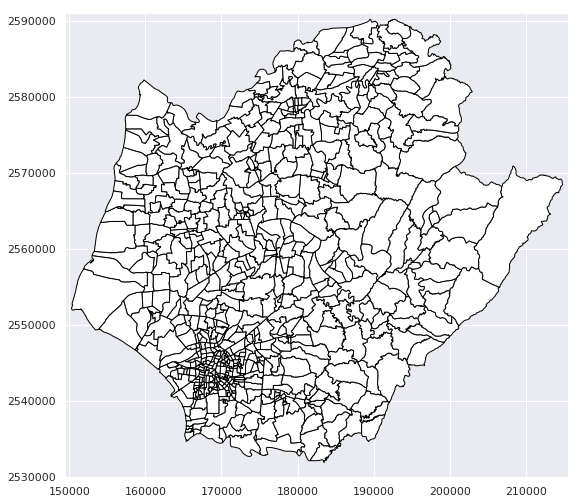

In [33]:
# We restrict to South America.
plt.rcParams['figure.figsize'] = [9, 9]

ax = tainan_shp.plot(color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
# geo_banks.plot(ax=ax, color='xkcd:light red', marker='.', markersize=5)
# ylim((, ))
axes = plt.gca()
axes.set_xlim([149500,215500])
axes.set_ylim([2530000,2591000])
plt.show()